Epoch [1/100], Training Loss: 1.5540, Training Acc: 32.14%, Validation Loss: 1.4705, Validation Acc: 40.71%
Epoch [2/100], Training Loss: 1.3842, Training Acc: 44.76%, Validation Loss: 1.3284, Validation Acc: 39.29%
Epoch [3/100], Training Loss: 1.2211, Training Acc: 42.86%, Validation Loss: 1.1741, Validation Acc: 41.43%
Epoch [4/100], Training Loss: 1.0899, Training Acc: 44.52%, Validation Loss: 1.0313, Validation Acc: 42.86%
Epoch [5/100], Training Loss: 0.9604, Training Acc: 59.52%, Validation Loss: 0.9069, Validation Acc: 65.71%
Epoch [6/100], Training Loss: 0.8372, Training Acc: 69.52%, Validation Loss: 0.8039, Validation Acc: 81.43%
Epoch [7/100], Training Loss: 0.7340, Training Acc: 81.90%, Validation Loss: 0.7146, Validation Acc: 91.43%
Epoch [8/100], Training Loss: 0.6458, Training Acc: 91.90%, Validation Loss: 0.6309, Validation Acc: 92.86%
Epoch [9/100], Training Loss: 0.5768, Training Acc: 92.86%, Validation Loss: 0.5578, Validation Acc: 95.00%
Epoch [10/100], Training Los

Epoch [77/100], Training Loss: 0.0118, Training Acc: 100.00%, Validation Loss: 0.0142, Validation Acc: 100.00%
Epoch [78/100], Training Loss: 0.0111, Training Acc: 100.00%, Validation Loss: 0.0142, Validation Acc: 100.00%
Epoch [79/100], Training Loss: 0.0103, Training Acc: 100.00%, Validation Loss: 0.0136, Validation Acc: 100.00%
Epoch [80/100], Training Loss: 0.0100, Training Acc: 100.00%, Validation Loss: 0.0137, Validation Acc: 100.00%
Epoch [81/100], Training Loss: 0.0108, Training Acc: 100.00%, Validation Loss: 0.0135, Validation Acc: 100.00%
Epoch [82/100], Training Loss: 0.0097, Training Acc: 100.00%, Validation Loss: 0.0131, Validation Acc: 100.00%
Epoch [83/100], Training Loss: 0.0094, Training Acc: 100.00%, Validation Loss: 0.0126, Validation Acc: 100.00%
Epoch [84/100], Training Loss: 0.0091, Training Acc: 100.00%, Validation Loss: 0.0125, Validation Acc: 100.00%
Epoch [85/100], Training Loss: 0.0091, Training Acc: 100.00%, Validation Loss: 0.0121, Validation Acc: 100.00%
E

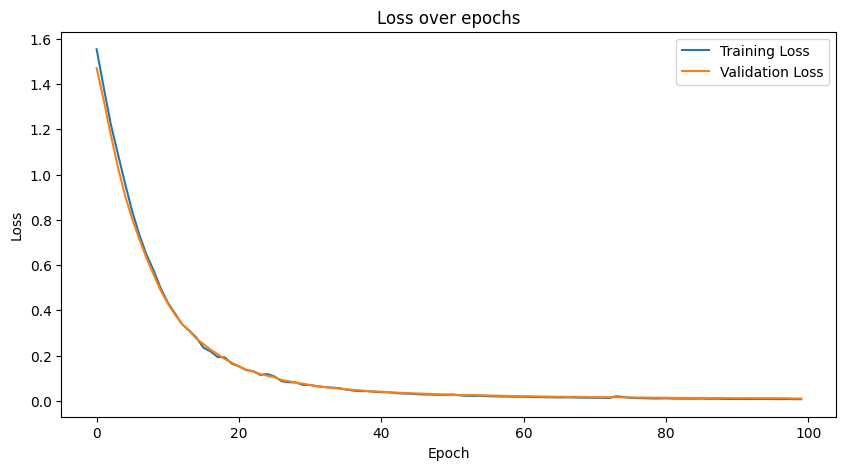

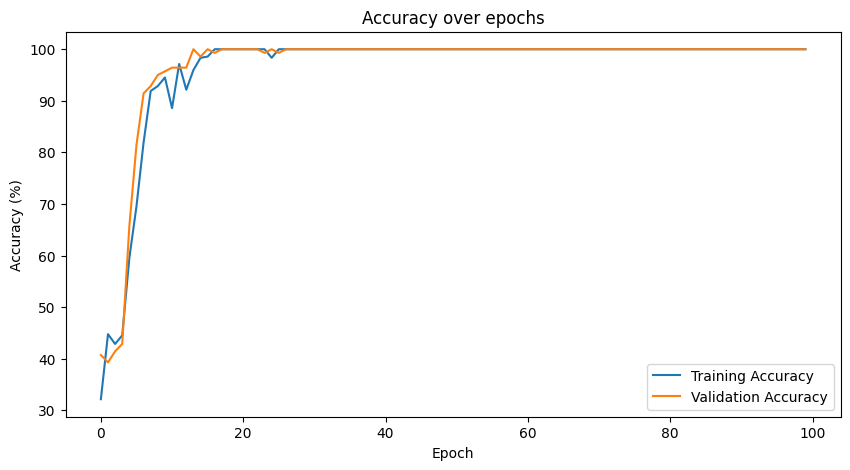

Test Accuracy: 100.00%


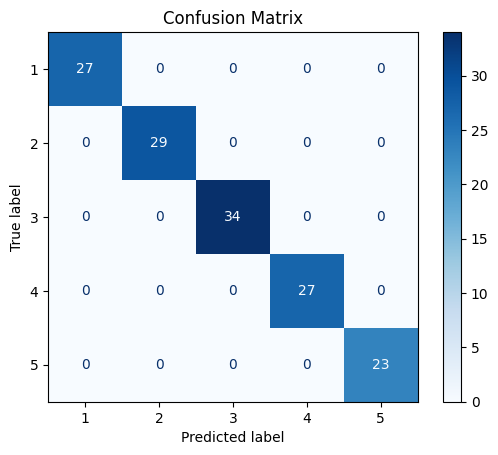

In [4]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# Load the dataset
data = pd.read_csv('user_behavior_dataset.csv')

# Select only the relevant features (columns 4, 5, and 8)
X = data.iloc[:, [3, 4, 7]].values  # Columns 4, 5, and 8 (0-indexed in pandas)

# Target (Column 11)
y = data.iloc[:, 10].values  # Column 11 (0-indexed)

# Adjust target labels to start from 0
y = y - 1  # Assuming classes are labeled from 1 to 5

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler to a file for later use
joblib.dump(scaler, 'scaler.pkl')

# Split into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 validation set

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # 3 input features
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 5)  # 5 output classes

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define loss function and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

# Lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with Early Stopping
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Acc: {epoch_acc:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_labels = []
all_predicted = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
